In [2]:
import torch

from models.configurations import TEXT_PRETRAINED, VISION_PRETRAINED
from models.segmenter import AdaptorSegmenter
from models.adaptor import Adaptor
from models.seg_models import DINOv2Segmenter, ResNetAEUNet

from utils.model_utils import get_newest_ckpt
from dataset.dataset import clf_collator
from dataset.configurations import DATASET_CFG
from dataset.data_module import AdaptorDataModule#
from utils.model_utils import load_vision_model

import numpy as np

In [13]:
task = "segment"
vision_model = "dinov2-b"
text_model = "bert"
# dataset = "rsna"
dataset = "siim"

crop_size = 896
batch_size = 1

vision_model_config = VISION_PRETRAINED[vision_model]
vision_pretrained = vision_model_config["pretrained_weight"]
vision_model_type = vision_model_config["vision_model_type"]

# dataset_cfg = DATASET_CFG["clf"][dataset]
dataset_cfg = DATASET_CFG["seg"][dataset]
dataset_class = dataset_cfg["class"]
dataset_kwargs = dataset_cfg["kwargs"]
data_transform = vision_model_config["data_transform"]

data_module = AdaptorDataModule(
    dataset=dataset_class,
    collate_fn=clf_collator,
    transforms=data_transform,
    data_pct=1.0,
    batch_size=batch_size,
    num_workers=4,
    crop_size=crop_size,
    seed=1117,
    **dataset_kwargs,
)
data_module.setup(stage="test")

test_dataset = data_module.datasets['test']#.shuffle(seed=42)
loader = torch.utils.data.DataLoader(test_dataset, batch_size=data_module.batch_size, num_workers=1, collate_fn=clf_collator)

In [14]:
import os
task = "segment"

models_dir = f"/vol/bitbucket/jq619/adaptor-thesis/trained_models/{task}/{vision_model}_{text_model}_{dataset}_1.0/adaptor_{task}_v3_{dataset}/"
ckpt_dir = os.path.join(models_dir, os.listdir(models_dir)[0], "checkpoints")
model_ckpt = os.path.join(ckpt_dir, os.listdir(ckpt_dir)[0])

In [15]:
adaptor_ckpt = get_newest_ckpt(
    vision_model, text_model, postfix="v3", 
    project_name="adaptor_pretrain_v3", 
)

adaptor = Adaptor.load_from_checkpoint(adaptor_ckpt)
adaptor.eval()

backbone = load_vision_model(
    vision_model_type=vision_model_type,
    vision_pretrained=vision_pretrained,
    retain_head=False,
)
if vision_model == "resnet-ae":
    seg_model = ResNetAEUNet(
        adaptor=adaptor,
        pretrained=False,
        out_channels=1,
        freeze_adaptor=True,
        input_size=crop_size,
    )

elif vision_model.startswith("dinov2-"):
    backbone = load_vision_model(
        vision_model_type=vision_model_type,
        vision_pretrained=vision_pretrained,
        retain_head=False,
    )
    seg_model = DINOv2Segmenter(
        backbone=backbone,
        adaptor=adaptor,
        hidden_dim=adaptor.projection_dim,
        out_channels=1,
        features=[512, 256, 128, 64],
        freeze_adaptor=True,
        input_size=crop_size,
    )
else:
    raise NotImplementedError

Using cache found in /homes/jq619/.cache/torch/hub/facebookresearch_dinov2_main
Using cache found in /homes/jq619/.cache/torch/hub/facebookresearch_dinov2_main


In [16]:
segmenter = AdaptorSegmenter.load_from_checkpoint(
    model_ckpt, 
    seg_model=seg_model,
)

segmenter.eval()

AdaptorSegmenter(
  (model): DINOv2Segmenter(
    (encoder): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0): NestedTensorBlock(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU(approximate=none)
            (fc2): Linear(in_features=3072, out_features=768, bias=

In [ ]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained(TEXT_PRETRAINED[text_model])
bert = BertModel.from_pretrained(TEXT_PRETRAINED[text_model])

text = "pnemonia"
inputs = tokenizer(text, return_tensors="pt")
text_inputs = bert(**inputs)["pooler_output"].detach()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  1%|          | 10/1704 [01:28<3:43:12,  7.91s/it]

Dice: 0.6349470615386963


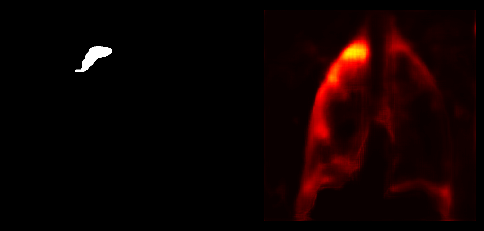

  1%|          | 11/1704 [01:49<4:52:08, 10.35s/it]

Dice: 0.7583653926849365


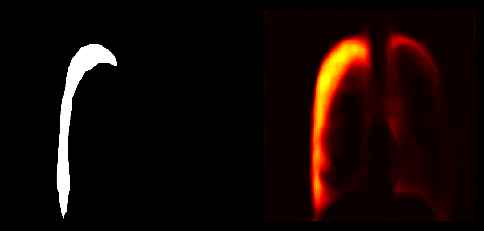

  1%|          | 14/1704 [02:09<4:08:11,  8.81s/it]

In [36]:
from tqdm import tqdm
from math import ceil


n_samples = 10
i = 0

pre_adaptor_embeddings_list = [] 
embeddings_list = []
labels_list = []

# Ensure no gradients are computed
with torch.no_grad():
    for idx, batch in enumerate(tqdm(loader)):     
        inputs, labels = batch['pixel_values'], batch['labels']
        if labels.sum() == 0:
            continue
        inputs = inputs.to(segmenter.device)
        outputs = segmenter.model(inputs)
        prob = torch.sigmoid(outputs)
        dice = segmenter.get_dice(prob, labels.unsqueeze(0))
        if dice > 0.6:
            print(idx, "Dice:", dice)
            i += 1    
            fig, ax = plt.subplots(1, 2, figsize=(6, 3))
            ax[0].matshow(labels.detach().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
            ax[1].matshow(prob.squeeze(1)[0].detach().cpu().numpy(), cmap='hot', vmin=0, vmax=1)
            
            ax[0].axis('off')
            ax[1].axis('off')
            plt.show()
            if i == n_samples:
                break

### old attempt

In [51]:
text_outputs = adaptor(text_inputs)
text_outputs = text_outputs / text_outputs.norm(dim=-1)

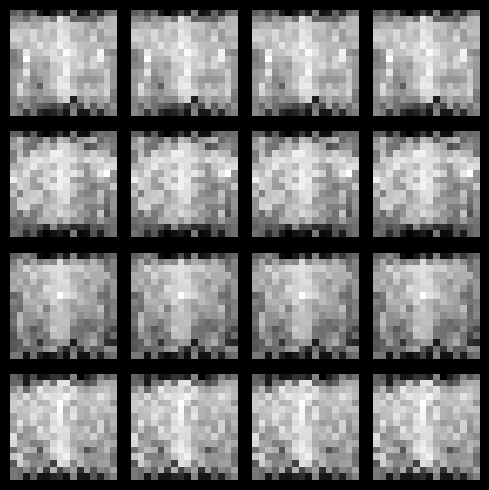

In [68]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 4, figsize=(5, 5))

for i in range(4):
    for j in range(4):
        ax[i, j].imshow((local_embeddings @ text_outputs.T).squeeze(-1).reshape(-1, 16, 16)[i].detach().cpu().numpy(), cmap='gray')
        ax[i, j].axis('off')
        
plt.tight_layout()
plt.show()